<a href="https://colab.research.google.com/github/anoopsanka/retinal_oct/blob/main/notebooks/OCT_MixtureModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
# needed to use rotate....
!pip install -U tensorflow_addons
!pip install -U wandb
!pip install envyaml
!git clone https://github.com/anoopsanka/retinal_oct

In [3]:
%cd retinal_oct

/content/retinal_oct


Shuffling and writing examples to /root/tensorflow_datasets/retina_dataset/1.0.0.incompleteFF2FCX/retina_dataset-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/retina_dataset/1.0.0.incompleteFF2FCX/retina_dataset-test.tfrecord


Dataset retina_dataset downloaded and prepared to /root/tensorflow_datasets/retina_dataset/1.0.0. Subsequent calls will reuse this data.


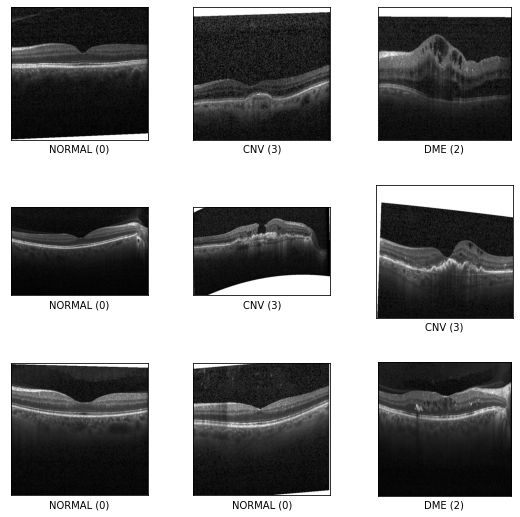

In [4]:
import tensorflow_datasets as tfds
from importlib.util import find_spec
if find_spec("core") is None:
    import sys
    sys.path.append('..')
    
from core.datasets import RetinaDataset

ds_train, ds_train_info = tfds.load('RetinaDataset', split='train', shuffle_files=False, as_supervised=True, with_info=True)
ds_test                 = tfds.load('RetinaDataset', split='test',  shuffle_files=False, as_supervised=True)

fig = tfds.show_examples(ds_train, ds_train_info)

In [15]:
import numpy as np
from sklearn.semi_supervised import LabelSpreading
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix, classification_report

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import umap

In [16]:
all_train_proj   = np.load('/content/drive/MyDrive/fourthbrain-ai/train_proj.npy')
all_train_logits = np.load('/content/drive/MyDrive/fourthbrain-ai/train_logits.npy')
all_train_labels = np.load('/content/drive/MyDrive/fourthbrain-ai/train_labels.npy')
all_train_resnet_embed   = np.load('/content/drive/MyDrive/fourthbrain-ai/train_resnet_proj.npy')
all_train_proj_normed = all_train_proj / ((all_train_proj**2.0).sum(axis=-1, keepdims=True))**0.5

In [17]:
def embedding_dimension_reduction(embedding, 
                                  labels, 
                                  reduced_dimension = 8, 
                                  method = 'UMAP',
                                  metric = 'cosine', 
                                  pairplot=False, 
                                  baseline_regression = False):

  if method == 'UMAP':
    reducer           = umap.UMAP(n_components= reduced_dimension, metric=metric,)
    reduced_embedding = reducer.fit_transform(embedding)
  elif method == 'PCA':
    reducer           = PCA(n_components= reduced_dimension, whiten=True)
    
    reduced_embedding = reducer.fit_transform(embedding)

  if pairplot:
    df = pd.DataFrame()
    for i in range(reduced_dimension):
      df[f'{method}{i+1}'] = reduced_embedding[:,i]
    df['class'] = labels
    sns.pairplot(df.sample(968), hue='class', palette='tab10', corner=True,)
  
  if baseline_regression:
    clf   = LogisticRegression( penalty='l2', max_iter=1000, class_weight='balanced').fit(reduced_embedding, labels)
    ypred = clf.predict(reduced_embedding)

    print(classification_report(labels, ypred))
    label_names_list = ds_train_info.features['label'].names
    plot_confusion_matrix(clf, 
                          reduced_embedding, 
                          labels, 
                          normalize='true', 
                          display_labels=label_names_list, 
                          cmap='inferno')

  return reduced_embedding

              precision    recall  f1-score   support

           0       0.84      0.82      0.83     26318
           1       0.35      0.55      0.43      8616
           2       0.72      0.77      0.74     11350
           3       0.94      0.82      0.88     37205

    accuracy                           0.78     83489
   macro avg       0.71      0.74      0.72     83489
weighted avg       0.82      0.78      0.80     83489



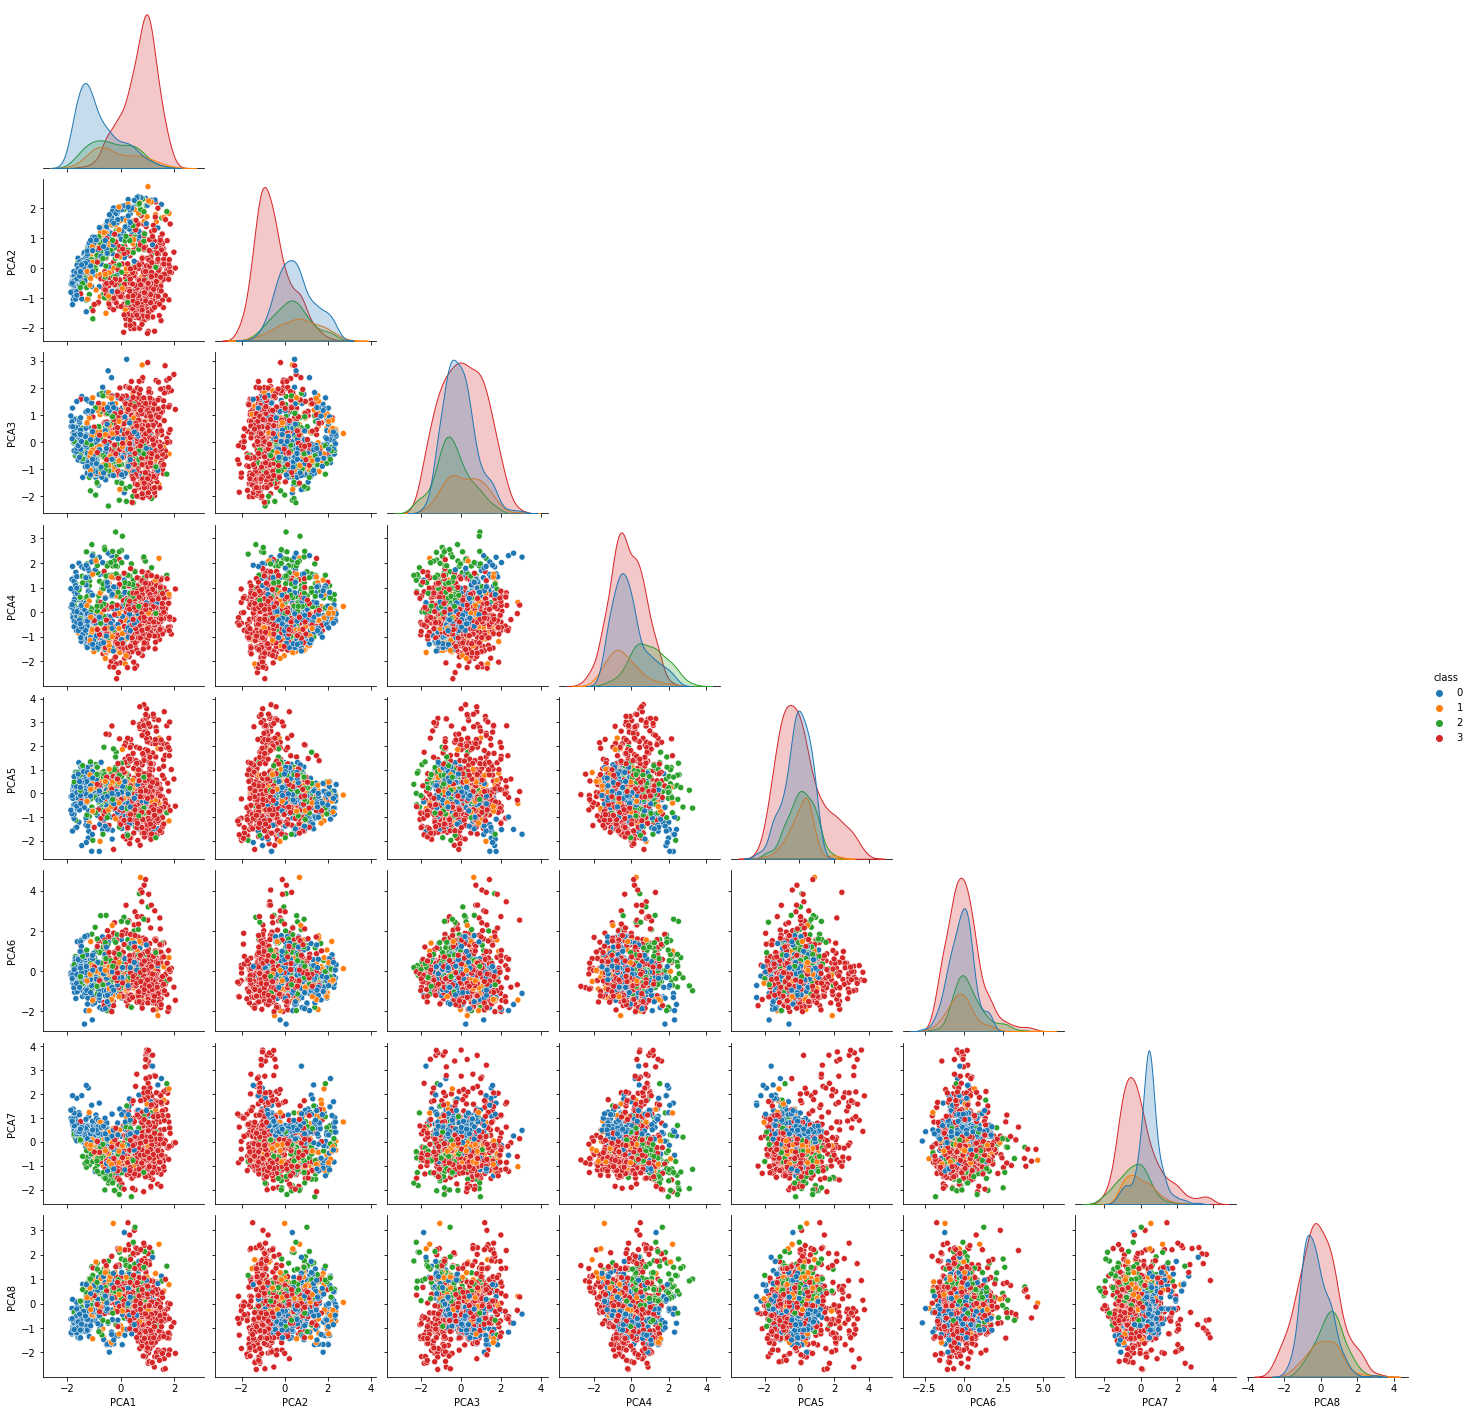

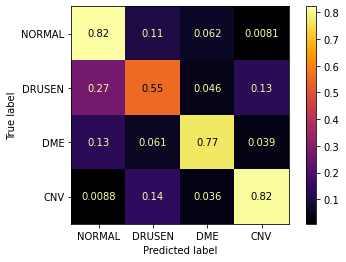

In [18]:
resnet_proj_PCA = embedding_dimension_reduction(all_train_resnet_embed, 
                                                all_train_labels.argmax(-1), 
                                                method='PCA',
                                                reduced_dimension=8,
                                                pairplot=True,
                                                baseline_regression=True)

              precision    recall  f1-score   support

           0       0.79      0.77      0.78     26318
           1       0.33      0.43      0.38      8616
           2       0.57      0.68      0.62     11350
           3       0.94      0.84      0.89     37205

    accuracy                           0.75     83489
   macro avg       0.66      0.68      0.67     83489
weighted avg       0.78      0.75      0.76     83489



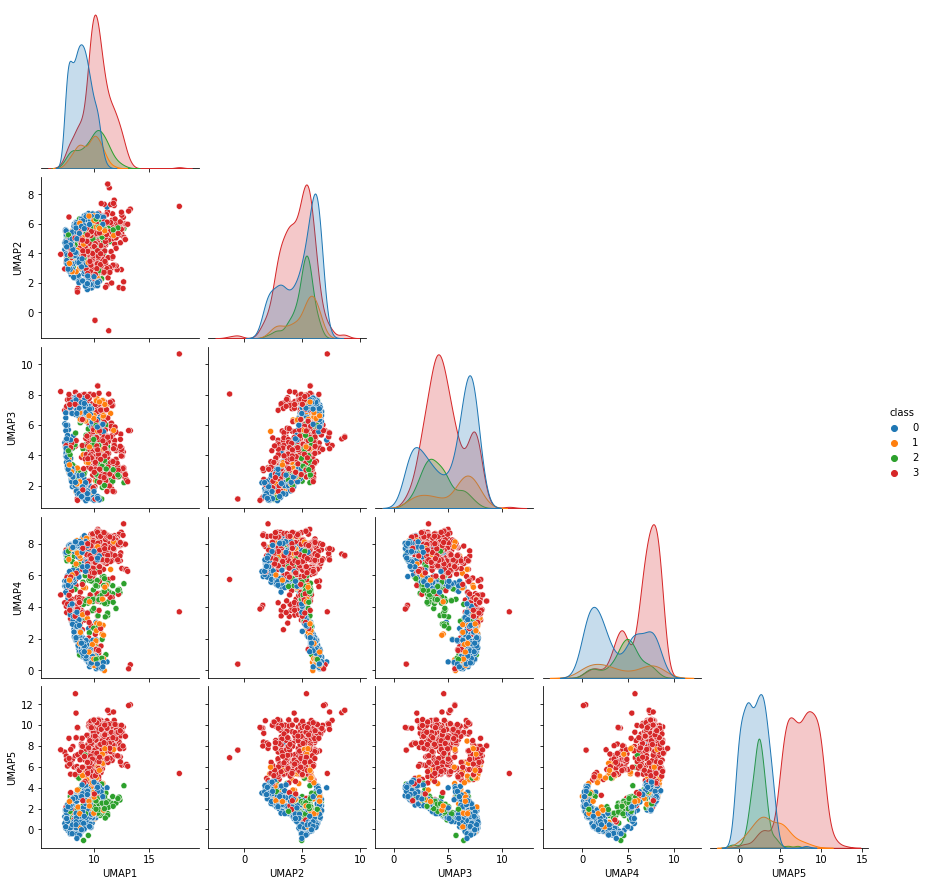

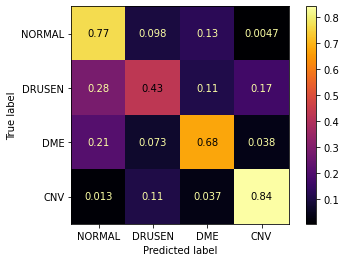

In [19]:
resnet_proj_UMAP = embedding_dimension_reduction(all_train_resnet_embed, 
                                                all_train_labels.argmax(-1), 
                                                method='UMAP', 
                                                 pairplot=True, 
                                                 baseline_regression=True, 
                                                 reduced_dimension=5)

# Download Pretrained Model
- uncomment the following line to download the weights

In [6]:
from core.models.simclr_model import Pretrained_SimCLR_Model
import wandb
api = wandb.Api()
run = api.run("hisunnytang/OCT-keras-SimCLR/1ipksk06")
run.file("weights.108-0.97.hdf5").download()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


<_io.TextIOWrapper name='./weights.108-0.97.hdf5' mode='r' encoding='UTF-8'>

In [8]:
import os
import random
import tensorflow as tf
import numpy as np
# Set the random seeds
os.environ['TF_CUDNN_DETERMINISTIC'] = '1' 
random.seed(hash("setting random seeds") % 2**32 - 1)
np.random.seed(hash("improves reproducibility") % 2**32 - 1)
tf.random.set_seed(hash("by removing stochasticity") % 2**32 - 1)

# Pure Label Smoothing

In [9]:
import tensorflow as tf
# goal here is given some index
def resize_only(img, lb, img_size=128):
  img = tf.image.resize(img, (img_size,img_size))
  img = tf.cast(img, tf.float32) / 255.
  return img, tf.one_hot(lb, 4)

def retrieve_images(index, batch_size=64):
  count = 0

  images = []
  labels = []

  index_test = index[:]

  counter = 1
  for X, y in ds_train.map(resize_only).batch(batch_size):

    current_batch_idx = index_test // (batch_size * counter)
    current_X_idx     = (index_test % batch_size)[current_batch_idx==0]
    
    images.append(X.numpy()[current_X_idx])
    labels.append(y.numpy()[current_X_idx].argmax(-1))

    # update the index_test to ignore batch that has been seen before
    index_test = index_test[current_batch_idx!=0]

    counter += 1
  return np.vstack(images), np.hstack(labels)

def select_uncertain_images(votes, images, labels, min_vote = 5):

  vote_count = votes.max(0)

  img_selected = images[vote_count < min_vote]
  lb_selected  = labels[vote_count < min_vote]
  return img_selected, lb_selected

In [10]:
def masked_labels_embedding(full_embedding, 
                            full_labels, 
                            sample_per_class = 1, 
                            max_sample_per_class = 1000):
  """retain only n sample per each class, masked the rest with label == -1
  Args:
    sample_per_class:     n labeled images per class
    max_sample_per_class: number of total sample per class
  Returns:
    embeddings, labeles_masked, labels_truth
  """
  # order the labels by the unique class
  unique_class     = 4

  embeddings_ordered = []
  labels_ordered     = []
  labels_masked      = []
  index_ordered      = []

  full_index = np.arange(len(full_embedding))
  for i in range(unique_class):
    flags = (full_labels == i)

    index = full_index[flags][:max_sample_per_class]

    # index = np.random.choice(full_index[flags], size=max_sample_per_class, replace=False)

    embeddings_ordered.append(full_embedding[index])
    labels_ordered.append(full_labels[index])


    idx = np.random.randint(0, max_sample_per_class,size=sample_per_class, )
    ones = np.ones(max_sample_per_class, )*-1
    ones[idx] = i
    labels_masked.append(ones)

    index_ordered.append(index)

  labels_masked = np.hstack(labels_masked).astype(int)
  labels_ordered = np.hstack(labels_ordered).astype(int)
  embeddings_ordered = np.vstack(embeddings_ordered)

  return embeddings_ordered, labels_masked, labels_ordered, index_ordered

# repeat label spreading n times to get uncertain labels
def fit_labelSpreading(embedding, partial_labels):
  model_lb_spread = LabelSpreading(kernel='rbf', alpha=0.1,)
  model_lb_spread.fit(embedding, partial_labels )
  return model_lb_spread.transduction_

def run_labelSpreading(embedding, labels, sample_per_class = 1, max_sample_per_class = 4000, ntimes = 10):
  ground_truth     = []
  predicted_labels = []
  for k in range(ntimes):
    partial_embedding, partial_label, truth_label, index = masked_labels_embedding(embedding, 
                                                                    labels, 
                                                                    sample_per_class = sample_per_class, 
                                                                    max_sample_per_class = max_sample_per_class)
    pred_labels = fit_labelSpreading(partial_embedding, partial_label)

    predicted_labels.append(pred_labels)
    ground_truth.append(truth_label)

  labels_pred_stacked = np.vstack(predicted_labels)
  label_vote = []

  for l in range(4):
    label_vote.append( (labels_pred_stacked == l).sum(axis=0))
  label_vote = np.vstack(label_vote)

  return label_vote, pred_labels, ground_truth, index

def select_uncertain_images(votes, images, labels, max_vote = 5):

  vote_count = votes.max(0)

  img_selected = images[vote_count < max_vote]
  lb_selected  = labels[vote_count < max_vote]
  return img_selected, lb_selected

In [20]:
def refine_layers_in_ResBlock(block, inputs, index_to_train = -2):
  """refine the bottom layer of the ResBlocks"""
  shortcut = inputs

  print(block.shortcut_layers)
  # lets not change the shortcut yet
  for layer in block.shortcut_layers:
    # Projection shortcut in first layer to match filters and strides
    shortcut = layer(shortcut)
    layer.trainable = True
  
  print(block.conv2d_bn_layers)
  for layer in block.conv2d_bn_layers[:index_to_train]:
    inputs = layer(inputs)
    layer.trainable = False

  for layer in block.conv2d_bn_layers[index_to_train:]:
    inputs = layer(inputs)
    layer.trainable = True
  
  return tf.nn.relu(inputs+shortcut)

In [57]:
def train_classification_model(train_dataset, 
                               val_dataset, 
                               img_size = 128, 
                               epochs = 50,
                               weight_file = 'weights.108-0.97.hdf5'):
  model = Pretrained_SimCLR_Model()
  input_shape_base   = (None, img_size, img_size, 3)
  input_shape_simclr = (None, img_size, img_size, 6)
  model.base_model.build(input_shape_base)
  model.build(input_shape_simclr)
  model.summary()
  model.load_weights(weight_file)


  input_layer   = tf.keras.Input((img_size, img_size,3))
  resnet_output = model.layers[0](input_layer)
  hidden        = tf.keras.layers.GlobalAveragePooling2D()(resnet_output)
  output        = tf.keras.layers.Dense(4, activation='softmax')(hidden)

  model_retrain = tf.keras.Model(input_layer, output)
  model_retrain.layers[1].trainable = False

  # optimizer = tf.keras.optimizers.Adam(1e-3)
  model_retrain.compile(loss = 'categorical_crossentropy', 
                        metrics=['accuracy'])
  model_retrain.summary()

  history = model_retrain.fit(train_dataset, 
                  validation_data = val_dataset.map(resize_only).batch(32), 
                  callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                                patience=3, 
                                                                restore_best_weights=True)],
                  epochs=epochs)
  
  print('-----------------------------------------------')
  model_retrain.evaluate(ds_test.map(resize_only).batch(32))
  print('-----------------------------------------------')

  # Rebuid the model by unfreezeing the last conv blocks
  # input_layer = tf.keras.Input((img_size,img_size,3))
  # x = input_layer
  # resnet_model = model_retrain.layers[1]
  # for l in resnet_model.layers[:-1]:
  #   x = l(x)
  #   l.trainable = False

  # last_block_group = resnet_model.layers[-1]
  # last_block_group.trainable = False

  # for l in last_block_group.layers[:-1]:
  #   x = l(x)
  #   l.trainable = False
  
  # final_resblock = last_block_group.layers[-1]
  # final_resblock.trainable = False
  # x = refine_layers_in_ResBlock(final_resblock, x, index_to_train=-2)
  # # for l in last_block_group.layers[:-1]:
  # #   x = l(x)
  # #   l.trainable = True
  
  # # # the last residual block
  # # last_resid_block = last_block_group.layers[-1]
  # # last_resid_block.trainable = True
  # # x = last_resid_block(x)

  # for l in model_retrain.layers[2:]:
  #   x = l(x)
  #   l.trainable = True

  model_retrain.layers[1].trainable = True

  # model_finetune = model_retrain

  optimizer = tf.keras.optimizers.Adam(1e-5)
  model_retrain.compile(loss = 'categorical_crossentropy', 
                        metrics=['accuracy'])
  model_retrain.summary()

  history = model_retrain.fit(train_dataset, 
                  validation_data = val_dataset.map(resize_only).batch(32), 
                  callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                                patience=5, )],
                  epochs=epochs)
  print('-----------------------------------------------')
  model_retrain.evaluate(ds_test.map(resize_only).batch(32))
  print('-----------------------------------------------')

  
  return model_retrain, history


from tensorflow.keras.preprocessing.image import ImageDataGenerator

def prepare_partial_dataset(img, lb, sample_weight=False):

  datagen = ImageDataGenerator(
      rotation_range=45,
      width_shift_range=0.2,
      height_shift_range=0.2, 
      horizontal_flip=True)

  onehot_lb = np.zeros((lb.size, lb.max()+1))
  onehot_lb[np.arange(lb.size), lb] = 1

  if sample_weight:
    w = np.bincount(lb)
    w = w.min() / w
    sample_weight = [w[i] for i in lb]
  else:
    sample_weight = np.ones_like(lb)

  train_data_generator = datagen.flow(
      img,
      y=onehot_lb,
      batch_size=32,
      shuffle=True,
      sample_weight = sample_weight,
      seed=42,
      )
  return train_data_generator

def extract_embedding(finetuned_model, dataset, layer_index = -1,):
  inputs = tf.keras.Input((128,128,3))
  x = inputs
  for l in finetuned_model.layers[:3]:
    x = l(x)

  tmp_model = tf.keras.Model(inputs, x)
  tmp_model.summary()

  embeddings  = []
  test_labels = []
  for X, y in dataset.map(resize_only).batch(32):
    embeddings.append(tmp_model.call(X, training=False).numpy())
    test_labels.append(y.numpy())
  return np.vstack(embeddings), np.vstack(test_labels).argmax(-1)

In [31]:
def run_experiments_labelsmoothing(embedding, 
                                   labels, 
                                   sample_per_class= 1, 
                                   max_sample_per_class = 1000, 
                                   ntimes = 10,
                                   max_vote = 5, 
                                   sample_weight = False,
                                   epochs = 50):

  labels = labels.argmax(-1)
  label_vote, pred_labels, ground_truth, index_embeding = run_labelSpreading(embedding, 
                                                                             labels,
                                                                             sample_per_class = sample_per_class, 
                                                                             max_sample_per_class = max_sample_per_class,
                                                                             ntimes = ntimes)

  index_to_retrieve = np.vstack(index_embeding)
  images, labels    = retrieve_images(index_to_retrieve, batch_size=256)

  img_selected, lb_selected = select_uncertain_images(label_vote, 
                                                      images, 
                                                      labels, 
                                                      max_vote=max_vote)
  
  ds_train_ppl = prepare_partial_dataset( img_selected, lb_selected, sample_weight=sample_weight)
  ds_val_subsample,   ds_train_info = tfds.load('RetinaDataset', 
                                                split='train[10:12%]', 
                                                shuffle_files=False, 
                                                as_supervised=True,
                                                with_info=True)

  model_ppl, history_ppl = train_classification_model(ds_train_ppl, ds_val_subsample, epochs=epochs)
  return model_ppl, history_ppl

# Pure Label Smoothing
- select 1000 sample from each class (arbitarily)
- and feed one labeled data per class
- run label propagation
- extract most uncertain ones
- then finetune the training model

In [32]:
model_ppl_pca, history_ppl_pca = run_experiments_labelsmoothing(resnet_proj_PCA, 
                                                                all_train_labels, 
                                                                sample_weight = True,
                                                                max_sample_per_class= 1000,
                                                                ntimes = 20, 
                                                                max_vote = 10,)

/usr/local/lib/python3.6/dist-packages/sklearn/semi_supervised/_label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer
/usr/local/lib/python3.6/dist-packages/sklearn/semi_supervised/_label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer
/usr/local/lib/python3.6/dist-packages/sklearn/semi_supervised/_label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer
/usr/local/lib/python3.6/dist-packages/sklearn/semi_supervised/_label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer
/usr/local/lib/python3.6/dist-packages/sklearn/semi_supervised/_label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer
/usr/local/lib/python3.6/dist-packages/sklearn/semi_sup

Model: "pretrained__sim_clr__model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet_3 (Resnet)            multiple                  11190464  
_________________________________________________________________
head_supervised (SupervisedH multiple                  2052      
_________________________________________________________________
projection_head_3 (Projectio multiple                  594304    
Total params: 11,786,830
Trainable params: 11,774,788
Non-trainable params: 12,042
_________________________________________________________________
Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
resnet_3 (Resnet)            (None, 4, 4, 512)         11190464  
____

In [33]:
model_ppl_umap, history_ppl_map = run_experiments_labelsmoothing(resnet_proj_UMAP, 
                                                                all_train_labels, 
                                                                sample_weight = True,
                                                                max_sample_per_class= 1000,
                                                                ntimes = 20, 
                                                                max_vote = 10,)

/usr/local/lib/python3.6/dist-packages/sklearn/semi_supervised/_label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer
/usr/local/lib/python3.6/dist-packages/sklearn/semi_supervised/_label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer
/usr/local/lib/python3.6/dist-packages/sklearn/semi_supervised/_label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer
/usr/local/lib/python3.6/dist-packages/sklearn/semi_supervised/_label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer
/usr/local/lib/python3.6/dist-packages/sklearn/semi_supervised/_label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer
/usr/local/lib/python3.6/dist-packages/sklearn/semi_sup

Model: "pretrained__sim_clr__model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet_4 (Resnet)            multiple                  11190464  
_________________________________________________________________
head_supervised (SupervisedH multiple                  2052      
_________________________________________________________________
projection_head_4 (Projectio multiple                  594304    
Total params: 11,786,830
Trainable params: 11,774,788
Non-trainable params: 12,042
_________________________________________________________________
Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
resnet_4 (Resnet)            (None, 4, 4, 512)         11190464  
____

Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        [(None, 128, 128, 3)]     0         
_________________________________________________________________
input_5 (InputLayer)         multiple                  0         
_________________________________________________________________
resnet_3 (Resnet)            (None, 4, 4, 512)         11190464  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 512)               0         
Total params: 11,190,464
Trainable params: 11,180,736
Non-trainable params: 9,728
_________________________________________________________________
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       242
           1       0.96      0.93      0.95       242
           2       1.00      0.95      0.97       242
           3       0.95

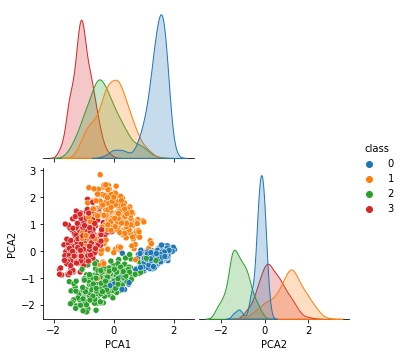

In [64]:
ppl_outlier_pred = model_ppl_pca.predict(ds_test.map(resize_only).batch(32))
embed, ground_truth = extract_embedding(model_ppl_pca, ds_test)
embedding_dimension_reduction(embed, ground_truth, method='PCA', pairplot=True, reduced_dimension=2)
print(classification_report(ground_truth, ppl_outlier_pred.argmax(-1)))

# Clustering: KMeans

In [37]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples

In [38]:
def sample_labeled_data_with_mask(embedding, 
                                  labels, 
                                  masks, 
                                  sample_per_class=1):
  unique_class = np.unique(labels)
  global_index = np.arange(len(embedding))[masks]

  local_embed  = embedding[global_index]
  local_labels = labels[global_index]

  global_index_output = []
  embedding_output    = []
  labels_masked       = []
  ground_truth        = []

  for i in range(len(unique_class)):
    index_pure_class = (local_labels == i)
    embed_pure_class = local_embed[index_pure_class]
    label_pure_class = local_labels[index_pure_class]

    num_samples = sum(index_pure_class)

    idx = np.random.randint(0, num_samples,size=sample_per_class)
    ones = np.ones(num_samples, )*-1
    ones[idx] = i
    labels_masked.append(ones)

    global_index_output.append(global_index[index_pure_class])
    embedding_output.append(embed_pure_class)
    ground_truth.append(label_pure_class)

  return np.vstack(embedding_output), np.hstack(labels_masked), np.hstack(ground_truth), np.hstack(global_index_output)

def run_labelSpreading_withMask(embedding, 
                                labels, 
                                masks,
                                sample_per_class = 1, 
                                ntimes = 10):
  ground_truth     = []
  predicted_labels = []
  for k in range(ntimes):
    partial_embedding, partial_labels, partial_truth, partial_index = sample_labeled_data_with_mask(embedding, labels)

    pred_labels = fit_labelSpreading(embedding, labels, masks)

    predicted_labels.append(pred_labels)
    ground_truth.append(truth_label)

  labels_pred_stacked = np.vstack(predicted_labels)
  label_vote = []

  for l in range(4):
    label_vote.append( (labels_pred_stacked == l).sum(axis=0))
  label_vote = np.vstack(label_vote)

  return label_vote, pred_labels, ground_truth, index

In [40]:
def run_experiments_KMeans_lb(embedding, 
                              labels, 
                              ntimes = 20,
                              max_vote = 10,
                              sample_per_class = 1,
                              n_clusters=4, 
                              n_dimension = 3,
                              sihouette_score_threshold = 0.1, 
                              sample_weight = True,
                              ):

  model_kmeans = KMeans(n_clusters=n_clusters, n_init=10)
  model_kmeans.fit(embedding[:, :n_dimension])

  pred_cluster = model_kmeans.labels_
  train_labels = labels.argmax(-1)

  # compute sihouette score for both true labels and the cluster labels
  sihouette_score_pred_labels = silhouette_samples(embedding[:,:n_dimension], pred_cluster)
  sihouette_score_true_labels = silhouette_samples(embedding[:,:n_dimension], train_labels)

  flags = sihouette_score_pred_labels < sihouette_score_threshold
  f, ax = plt.subplots(2,2)
  ax = ax.flat
  ax[0].scatter(embedding[:,0][flags], embedding[:,1][flags], c = train_labels[flags], cmap='viridis')
  ax[1].scatter(embedding[:,0][flags], embedding[:,1][flags], c = pred_cluster[flags], cmap='viridis')
  ax[0].set_title('true labels')
  ax[1].set_title('cluster labels')

  ax[2].hist(train_labels[flags])
  ax[3].hist(pred_cluster[flags])

  plt.show()


  # filter out images that are classified as outlier in KMeans
  index_kmeans = np.arange(len(sihouette_score_pred_labels))[flags]
  images_outlier_kmeans, labels_outlier_kmeans = retrieve_images(index_kmeans)

  # run label smoothing
  predicted_labels = []
  for i in range(ntimes):
    subsample_embed, subsample_masked_lb, subsample_gt, subsample_global_index = sample_labeled_data_with_mask(embedding[:, :n_dimension], 
                                                                                                              train_labels, 
                                                                                                              flags, 
                                                                                                              sample_per_class=sample_per_class,
                                                                                                              )
    pred_lb = fit_labelSpreading(subsample_embed, subsample_masked_lb)
    predicted_labels.append(pred_lb)
  labels_pred_stacked = np.vstack(predicted_labels)
  label_vote = []

  for l in range(4):
    label_vote.append( (labels_pred_stacked == l).sum(axis=0))
  label_vote = np.vstack(label_vote)

  # select the images based on the uncertainty of votes
  img_selected, lb_selected = select_uncertain_images(label_vote, 
                                                      images_outlier_kmeans, 
                                                      labels_outlier_kmeans, 
                                                      max_vote=max_vote)

  print(img_selected.shape)
  print(np.bincount(lb_selected))
  
  # train and finetune the classification model
  ds_train_ppl = prepare_partial_dataset(img_selected, lb_selected, sample_weight=True)
  ds_val_subsample = tfds.load('RetinaDataset', 
                                split='train[10:12%]', 
                                shuffle_files=False, 
                                as_supervised=True)

  model_kmeans, history_kmeans = train_classification_model(ds_train_ppl, ds_val_subsample)
  return model_kmeans, history_kmeans


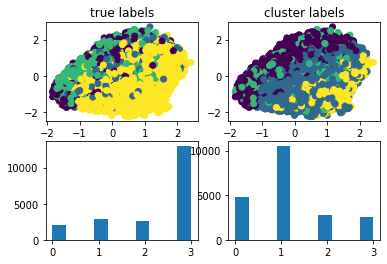

(11646, 128, 128, 3)
[1142 1650 1521 7333]
Model: "pretrained__sim_clr__model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet_5 (Resnet)            multiple                  11190464  
_________________________________________________________________
head_supervised (SupervisedH multiple                  2052      
_________________________________________________________________
projection_head_5 (Projectio multiple                  594304    
Total params: 11,786,830
Trainable params: 11,774,788
Non-trainable params: 12,042
_________________________________________________________________
Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 128, 128, 3)]     0         
_________________________________________________________________
resnet_5 (Resnet)          

In [41]:
model_kmeans_finetuned, history_kmeans_finetuned = run_experiments_KMeans_lb(resnet_proj_PCA, 
                                                                             all_train_labels, 
                                                                             ntimes = 20,
                                                                             max_vote = 10,
                                                                             sample_per_class = 1,
                                                                             n_clusters  = 4,
                                                                             n_dimension = 8,
                                                                             sihouette_score_threshold=0.1,
                                                                             sample_weight=True)

# KMeans Outlier

Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        [(None, 128, 128, 3)]     0         
_________________________________________________________________
input_10 (InputLayer)        multiple                  0         
_________________________________________________________________
resnet_5 (Resnet)            (None, 4, 4, 512)         11190464  
_________________________________________________________________
global_average_pooling2d_8 ( (None, 512)               0         
Total params: 11,190,464
Trainable params: 11,180,736
Non-trainable params: 9,728
_________________________________________________________________
              precision    recall  f1-score   support

           0       0.91      1.00      0.95       242
           1       1.00      0.93      0.96       242
           2       0.99      0.94      0.96       242
           3       0.97

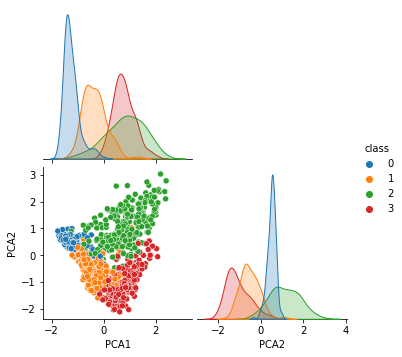

In [62]:
kmeans_outlier_pred = model_kmeans_finetuned.predict(ds_test.map(resize_only).batch(32))
embed, ground_truth = extract_embedding(model_kmeans_finetuned, ds_test)
embedding_dimension_reduction(embed, ground_truth, method='PCA', pairplot=True, reduced_dimension=2)
print(classification_report(ground_truth, kmeans_outlier_pred.argmax(-1)))

In [ ]:
kmeans_uncertain_pred = model_kmeans_finetuned.predict(ds_test.map(resize_only).batch(32))
print(classification_report( eee[1], kmeans_uncertain_pred.argmax(-1)))

              precision    recall  f1-score   support

           0       0.86      0.99      0.92       242
           1       0.97      0.85      0.91       242
           2       0.98      0.91      0.94       242
           3       0.94      0.98      0.96       242

    accuracy                           0.93       968
   macro avg       0.94      0.93      0.93       968
weighted avg       0.94      0.93      0.93       968



In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
import seaborn as sns

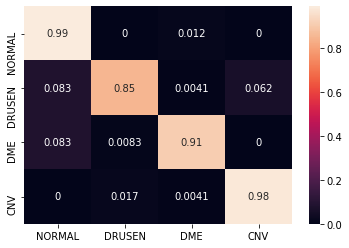

In [ ]:
cof_mat = confusion_matrix(eee[1], kmeans_uncertain_pred.argmax(-1))
df = pd.DataFrame(cof_mat, columns= ds_train_info.features['label'].names )
df.index = df.columns
sns.heatmap(df/ df.sum(axis=1), annot=True,)

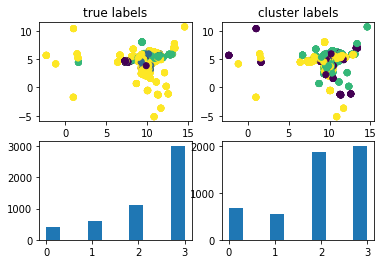

/usr/local/lib/python3.6/dist-packages/sklearn/semi_supervised/_label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer
/usr/local/lib/python3.6/dist-packages/sklearn/semi_supervised/_label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer
/usr/local/lib/python3.6/dist-packages/sklearn/semi_supervised/_label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer
/usr/local/lib/python3.6/dist-packages/sklearn/semi_supervised/_label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer
/usr/local/lib/python3.6/dist-packages/sklearn/semi_supervised/_label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer
/usr/local/lib/python3.6/dist-packages/sklearn/semi_sup

(1773, 128, 128, 3)
[ 138  188  377 1070]
Model: "pretrained__sim_clr__model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet_6 (Resnet)            multiple                  11190464  
_________________________________________________________________
head_supervised (SupervisedH multiple                  2052      
_________________________________________________________________
projection_head_6 (Projectio multiple                  594304    
Total params: 11,786,830
Trainable params: 11,774,788
Non-trainable params: 12,042
_________________________________________________________________
Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 128, 128, 3)]     0         
_________________________________________________________________
resnet_6 (Resnet)           

In [42]:
model_kmeans_umap, history_kmeans_map = run_experiments_KMeans_lb(resnet_proj_UMAP, 
                                                                  all_train_labels, 
                                                                  ntimes = 20,
                                                                  max_vote = 10,
                                                                  sample_per_class = 1,
                                                                  n_clusters  = 4,
                                                                  n_dimension = 8,
                                                                  sihouette_score_threshold=0.1,
                                                                  sample_weight=True)

UMAP embedding maybe not too useful here

# Gaussian Mixture Model
- with 4 components
- compute the z score for each data point with respect to each gaussian component
- $\rm{diag}\sqrt{( (x - \mu)^T\Sigma^{-1} (x - \mu) )}$
- taken data points that are 3 sigma away from the cluster center

In [44]:
from sklearn.mixture import GaussianMixture

In [45]:
def compute_zscore(X, gmm_results, batch_size=256):
  nbatches = len(X) // batch_size

  z_score1 = []
  z_score2 = []
  z_score3 = []
  z_score4 = []

  for b in range(nbatches):
    x = X[b*batch_size: (b+1)*batch_size, :]

    z_score1.append(( (x - gmm_results.means_[0]) @ np.linalg.inv(gmm_results.covariances_[0]) @ (x - gmm_results.means_[0]).T ).diagonal()**0.5)
    z_score2.append(( (x - gmm_results.means_[1]) @ np.linalg.inv(gmm_results.covariances_[1]) @ (x - gmm_results.means_[1]).T ).diagonal()**0.5)
    z_score3.append(( (x - gmm_results.means_[2]) @ np.linalg.inv(gmm_results.covariances_[2]) @ (x - gmm_results.means_[2]).T ).diagonal()**0.5)
    z_score4.append(( (x - gmm_results.means_[3]) @ np.linalg.inv(gmm_results.covariances_[3]) @ (x - gmm_results.means_[3]).T ).diagonal()**0.5)
    if b == nbatches - 1:
      x = X[(b+1)*batch_size:, :]

      z_score1.append(( (x - gmm_results.means_[0]) @ np.linalg.inv(gmm_results.covariances_[0]) @ (x - gmm_results.means_[0]).T ).diagonal()**0.5)
      z_score2.append(( (x - gmm_results.means_[1]) @ np.linalg.inv(gmm_results.covariances_[1]) @ (x - gmm_results.means_[1]).T ).diagonal()**0.5)
      z_score3.append(( (x - gmm_results.means_[2]) @ np.linalg.inv(gmm_results.covariances_[2]) @ (x - gmm_results.means_[2]).T ).diagonal()**0.5)
      z_score4.append(( (x - gmm_results.means_[3]) @ np.linalg.inv(gmm_results.covariances_[3]) @ (x - gmm_results.means_[3]).T ).diagonal()**0.5)
  return np.hstack(z_score1), np.hstack(z_score2), np.hstack(z_score3), np.hstack(z_score4) 

def run_experiments_GaussianMixture_lb(embedding, 
                                        labels, 
                                        ntimes = 10,
                                        max_vote = 5,
                                        sample_per_class = 1,
                                        n_clusters=4, 
                                        n_dimension = 3,
                                        z_threshold = 3.0,
                                        select_outlier = True,
                                        min_proba = 0.3,
                                        max_proba = 0.7,
                                       sample_weight = True,
                                        ):
  X = embedding[:, :n_dimension]
  gmm_results = GaussianMixture(n_components=4, n_init=10).fit(X)

  pred_cluster = gmm_results.predict(X)
  train_labels = labels.argmax(-1)

  zscore1, zscore2, zscore3, zscore4 = compute_zscore(X, gmm_results)

  if select_outlier:
    _flags =  np.logical_and.reduce((zscore1 > z_threshold, 
                                            zscore2 > z_threshold,
                                            zscore3 > z_threshold,
                                            zscore4 > z_threshold,))
    _index = np.arange(len(_flags))[_flags]

  else:
    gmm_pred = gmm_results.predict_proba(X)
    flag1 = np.logical_and(gmm_pred[:,0] < max_proba, gmm_pred[:,0] > min_proba )
    flag2 = np.logical_and(gmm_pred[:,0] < max_proba, gmm_pred[:,0] > min_proba )
    flag3 = np.logical_and(gmm_pred[:,1] < max_proba, gmm_pred[:,1] > min_proba )
    flag4 = np.logical_and(gmm_pred[:,2] < max_proba, gmm_pred[:,2] > min_proba )

    _flags = np.logical_or.reduce((flag1, flag2, flag3, flag4))
    _index = np.arange(len(_flags))[_flags]

  f, ax = plt.subplots(2,2)
  ax = ax.flat
  ax[0].scatter(X[:,0][_flags], X[:,1][_flags], c = train_labels[_flags], cmap='viridis')
  ax[1].scatter(X[:,0][_flags], X[:,1][_flags], c = pred_cluster[_flags], cmap='viridis')

  ax[0].set_title('true labels')
  ax[1].set_title('cluster labels')

  ax[2].hist(train_labels[_flags])
  ax[3].hist(pred_cluster[_flags])
  plt.show()

  print('retrieving images')
  # filter out images that are classified as outlier in KMeans
  images, labels = retrieve_images(_index)

  print('running label smoothing')
  # run label smoothing
  predicted_labels = []
  for i in range(ntimes):
    subsample_embed, subsample_masked_lb, subsample_gt, subsample_global_index = sample_labeled_data_with_mask(X[:, :n_dimension], 
                                                                                                              train_labels, 
                                                                                                              _flags, 
                                                                                                              sample_per_class=sample_per_class,
                                                                                                              )
    pred_lb = fit_labelSpreading(subsample_embed, subsample_masked_lb)
    predicted_labels.append(pred_lb)
  labels_pred_stacked = np.vstack(predicted_labels)
  label_vote = []

  for l in range(4):
    label_vote.append( (labels_pred_stacked == l).sum(axis=0))
  label_vote = np.vstack(label_vote)

  # select the images based on the uncertainty of votes
  img_selected, lb_selected = select_uncertain_images(label_vote, 
                                                      images, 
                                                      labels, 
                                                      max_vote=max_vote)
  
  print(img_selected.shape)
  print(np.bincount(lb_selected))

  # train and finetune the classification model
  ds_train_ppl = prepare_partial_dataset(img_selected, lb_selected, sample_weight=sample_weight)
  ds_val_subsample = tfds.load('RetinaDataset', 
                                split='train[10:12%]', 
                                shuffle_files=False, 
                                as_supervised=True)

  model_gmm, history_gmm = train_classification_model(ds_train_ppl, ds_val_subsample)
  return model_gmm, history_gmm


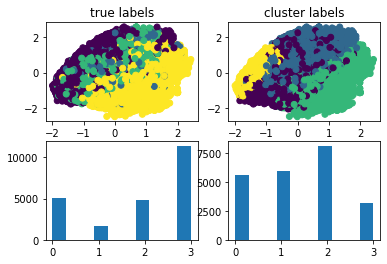

retrieving images
running label smoothing


/usr/local/lib/python3.6/dist-packages/sklearn/semi_supervised/_label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer
/usr/local/lib/python3.6/dist-packages/sklearn/semi_supervised/_label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


(11292, 128, 128, 3)
[2495  860 2313 5624]
Model: "pretrained__sim_clr__model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet_7 (Resnet)            multiple                  11190464  
_________________________________________________________________
head_supervised (SupervisedH multiple                  2052      
_________________________________________________________________
projection_head_7 (Projectio multiple                  594304    
Total params: 11,786,830
Trainable params: 11,774,788
Non-trainable params: 12,042
_________________________________________________________________
Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 128, 128, 3)]     0         
_________________________________________________________________
resnet_7 (Resnet)          

In [46]:
model_gmm_outlier, history_gmm_outlier = run_experiments_GaussianMixture_lb(resnet_proj_PCA, 
                                                            all_train_labels,
                                                            select_outlier = True,
                                                            sample_weight = True,
                                                            n_dimension = 8,
                                                            ntimes = 20,
                                                            max_vote = 10,)

Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        [(None, 128, 128, 3)]     0         
_________________________________________________________________
input_13 (InputLayer)        multiple                  0         
_________________________________________________________________
resnet_7 (Resnet)            (None, 4, 4, 512)         11190464  
_________________________________________________________________
global_average_pooling2d_11  (None, 512)               0         
Total params: 11,190,464
Trainable params: 11,180,736
Non-trainable params: 9,728
_________________________________________________________________
              precision    recall  f1-score   support

           0       0.93      0.99      0.96       242
           1       0.96      0.96      0.96       242
           2       1.00      0.90      0.95       242
           3       0.96

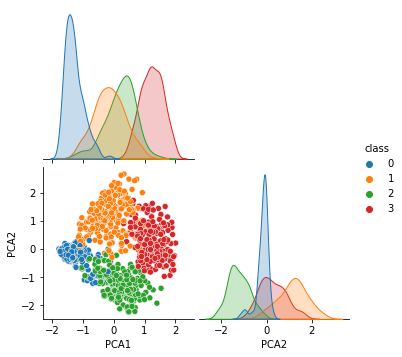

In [63]:
gmm_outlier_pred = model_gmm_outlier.predict(ds_test.map(resize_only).batch(32))
embed, ground_truth = extract_embedding(model_gmm_outlier, ds_test)
embedding_dimension_reduction(embed, ground_truth, method='PCA', pairplot=True, reduced_dimension=2)
print(classification_report(ground_truth, gmm_outlier_pred.argmax(-1)))

# GMM uncertain label

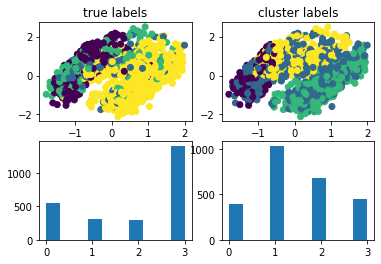

retrieving images
running label smoothing
(1004, 128, 128, 3)
[216 125 112 551]
Model: "pretrained__sim_clr__model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet_8 (Resnet)            multiple                  11190464  
_________________________________________________________________
head_supervised (SupervisedH multiple                  2052      
_________________________________________________________________
projection_head_8 (Projectio multiple                  594304    
Total params: 11,786,830
Trainable params: 11,774,788
Non-trainable params: 12,042
_________________________________________________________________
Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 128, 128, 3)]     0         
________________________________________________________

In [47]:
model_gmm_pca, history_gmm_pca = run_experiments_GaussianMixture_lb(resnet_proj_PCA, 
                                                            all_train_labels,
                                                            select_outlier = False,
                                                            sample_weight = True,
                                                            n_dimension = 8,
                                                            min_proba = 0.4, 
                                                            max_proba = 0.6,
                                                            ntimes = 20,
                                                            max_vote = 10,)

In [58]:
gmm_uncertain_pred = model_gmm_pca.predict(ds_test.map(resize_only).batch(32))
embed, ground_truth = extract_embedding(model_gmm_pca, ds_test)
embedding_dimension_reduction(embed, ground_truth, method='PCA', pairplot=True, reduced_dimension=2)
print(classification_report(ground_truth, gmm_uncertain_pred.argmax(-1)))

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        [(None, 128, 128, 3)]     0         
_________________________________________________________________
input_14 (InputLayer)        multiple                  0         
_________________________________________________________________
resnet_8 (Resnet)            (None, 4, 4, 512)         11190464  
_________________________________________________________________
global_average_pooling2d_12  (None, 512)               0         
Total params: 11,190,464
Trainable params: 11,180,736
Non-trainable params: 9,728
_________________________________________________________________
              precision    recall  f1-score   support

           0       0.91      0.99      0.95       242
           1       1.00      0.85      0.92       242
           2       0.99      0.93      0.96       242
           3       0.90